# imports

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import sys  
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from src.data.dataset_tracking import read_data, prepare_data, preprocess_data, generate_dataset
from src.visualization.visualize_tracking import plot_arrays
from src.models.constants_tracking import VAL_SPLIT, BATCH_SIZE, EPOCHS, INITIAL_LR
from src.models.point_net import get_shape_segmentation_model

2023-11-10 17:00:13.020125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 17:00:13.020163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 17:00:13.020196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 17:00:13.027718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# read and prepare data

## read data

In [2]:
data_file_path = '../data/raw/wire_tracking/test.npy'
full_data = read_data(data_file_path)
full_data.shape

(1236480, 4)

## prepare data

In [3]:
point_clouds, labels, labels_categorical = prepare_data(full_data=full_data)
print(point_clouds.shape, labels.shape, labels_categorical.shape)
labels

(1236480, 3) (1236480,) (1236480, 3)


array([1., 2., 2., ..., 2., 2., 2.])

## preprocessing

In [4]:
point_clouds, labels, labels_categorical = preprocess_data(point_clouds, labels, labels_categorical)
print(point_clouds.shape, labels.shape, labels_categorical.shape)

(9660, 128, 3) (9660, 128) (9660, 128, 3)


(9660, 128, 3) (9660, 128) (9660, 128, 3)


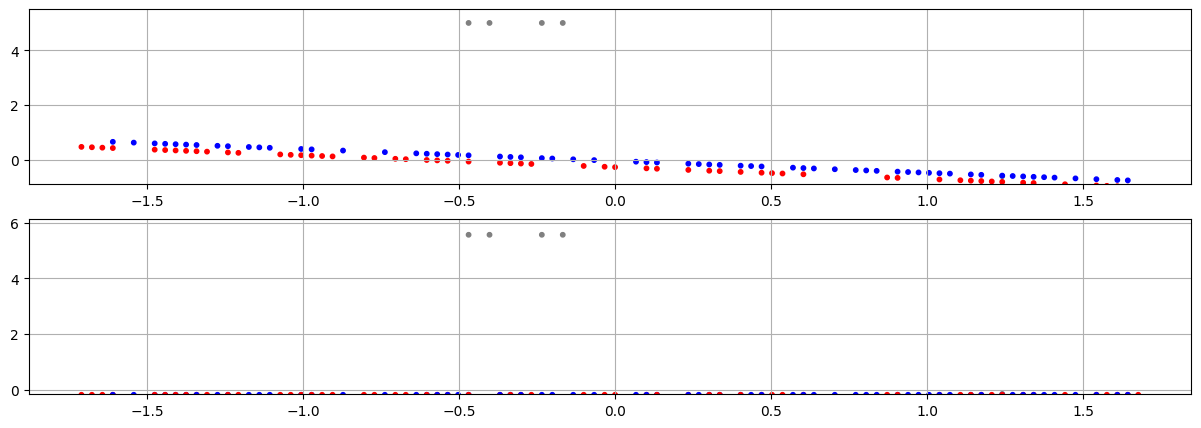

In [5]:
index = 521
print(point_clouds.shape, labels.shape, labels_categorical.shape)
plot_arrays(point_clouds[index,:,0], point_clouds[index,:,1], point_clouds[index,:,2], labels[index].astype('int'), figsize=(15,5))

# split data and generators

In [6]:
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = labels_categorical[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = labels_categorical[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 7728
Num train point cloud labels: 7728
Num val point clouds: 1932
Num val point cloud labels: 1932


2023-11-10 17:00:14.861416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 17:00:14.866013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 17:00:14.866210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 3), dtype=tf.float32, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 3), dtype=tf.float32, name=None))>


# Instantiate the model

In [7]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]
print(num_points, num_classes)
segmentation_model = get_shape_segmentation_model(num_points, num_classes)
# segmentation_model.summary()

128 3


# Training

Total training steps: 21690.


2023-11-10 17:00:15.732166: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


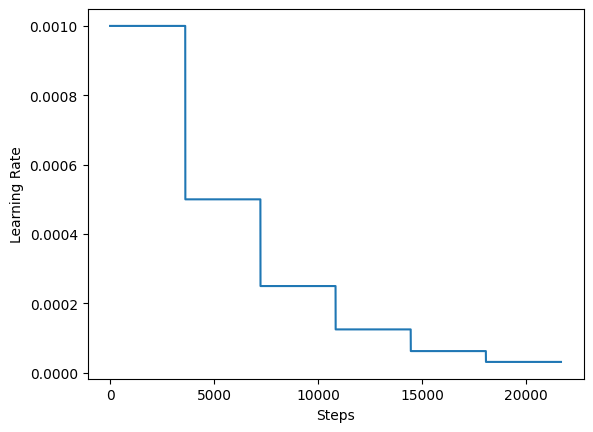

In [8]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

boundaries = [i * training_step_size * 15 for i in range(1,6)]
values = [INITIAL_LR / 2 ** i for i in range(6)]

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values,
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        # loss = dice_coef_loss,
        metrics=["accuracy"],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/90


2023-11-10 17:01:03.670808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-10 17:01:03.791979: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-10 17:01:04.530760: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1ee451f5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 17:01:04.530784: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-11-10 17:01:04.534472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 17:01:04.610327: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


242/242 [==============================] - 17s 33ms/step - loss: 5.0616 - accuracy: 0.7053 - val_loss: 4.9753 - val_accuracy: 0.8426
Epoch 2/90
242/242 [==============================] - 7s 28ms/step - loss: 4.4670 - accuracy: 0.8893 - val_loss: 33722500.0000 - val_accuracy: 0.7198
Epoch 3/90
242/242 [==============================] - 7s 28ms/step - loss: 4.4296 - accuracy: 0.9099 - val_loss: 10.9719 - val_accuracy: 0.9382
Epoch 4/90
242/242 [==============================] - 7s 30ms/step - loss: 4.4979 - accuracy: 0.8944 - val_loss: 4.4121 - val_accuracy: 0.9103
Epoch 5/90
242/242 [==============================] - 7s 28ms/step - loss: 4.4403 - accuracy: 0.9125 - val_loss: 6.1636 - val_accuracy: 0.8548
Epoch 6/90
242/242 [==============================] - 7s 29ms/step - loss: 4.2819 - accuracy: 0.9567 - val_loss: 4.2521 - val_accuracy: 0.9631
Epoch 7/90
242/242 [==============================] - 7s 29ms/step - loss: 4.2536 - accuracy: 0.9672 - val_loss: 4.2472 - val_accuracy: 0.9607
E

# plot history

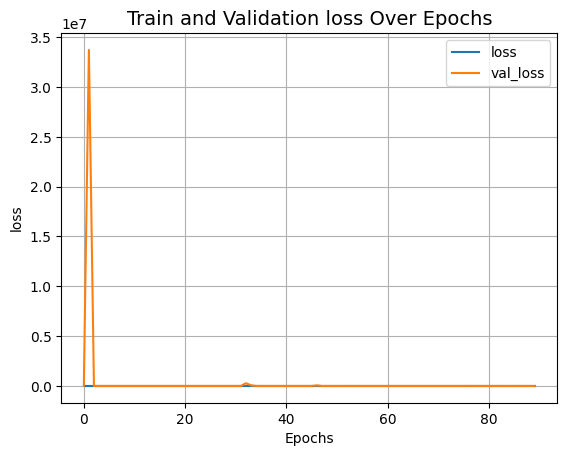

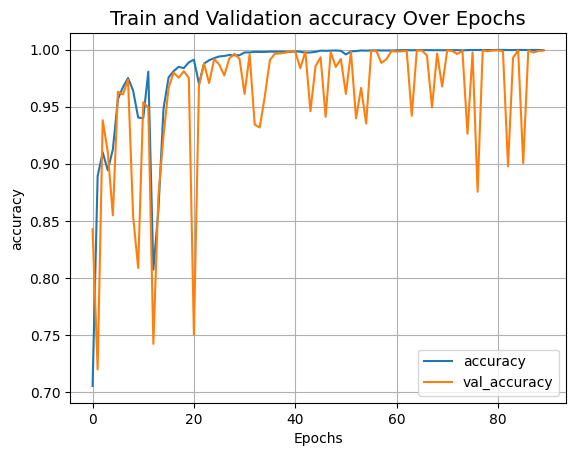

In [10]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

# Inference

1/1 [==============================] - 0s 12ms/step
Validation prediction shape: (32, 128, 3)


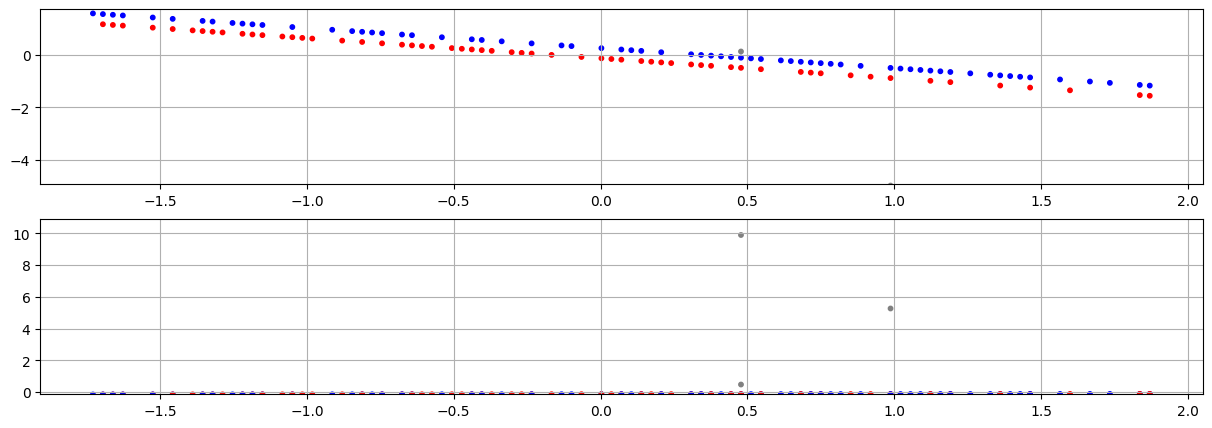

In [19]:
validation_batch = next(iter(val_dataset))

val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

predict_labels = np.argmax(val_predictions, axis = -1)
val_labels = np.argmax(validation_batch[1], axis = -1)
point_cloud_batch = validation_batch[0].numpy()
index = 4
plot_arrays(point_cloud_batch[index,:,0], point_cloud_batch[index,:,1], point_cloud_batch[index,:,2], predict_labels[index].astype('int'), figsize=(15,5))

# Save model

In [12]:
# segmentation_model.save('./model', save_format='tf')